In [1]:
from models import RNNModel
import numpy as np
import pandas as pd
import joblib
from data import readLocally
from sklearn.metrics import confusion_matrix
from visualization import plot_roc_auc, pr_curve, format_vertical_headers, print_confusion_matrix, printModelData

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X_train, y_train, X_test, y_test, X_val, y_val, labels_hash, scaler = readLocally()




_ _ _ _ _ _ _ _ _ _   READ DATA LOCALLY  _ _ _ _ _ _ _ _ _ _ 




SHAPES & KEYS:
    X_train          : (285428, 25, 12)   -> 48%
    y_train          : (285428,)
    X_test           : (237858, 25, 12)   -> 40%
    y_test           : (237858,)
    X_val            : (71357, 25, 12)   -> 12%
    y_val            : (71357,)
    ______________________
    Total Data Size  : 594643
    labels_hash Keys : dict_keys(['customer', 'age', 'gender', 'merchant', 'category'])
    
    TRAIN DATA
    ______________________
    Positives        : 3461   -> 1.21%
    Negatives        : 281967   -> 98.79%
    
    TEST DATA
    ______________________
    Positives        : 2839   -> 1.19%
    Negatives        : 235019   -> 98.81%   
    
    VAL DATA
    ______________________
    Positives        : 900   -> 1.26%
    Negatives        : 70457   -> 98.74%
    


In [4]:
#DIVIDE X_TEST IN HALF AND ADD IT TO X_TRAIN
test_half_pos   = int(len(X_test)/2)
total_data_size = len(X_train) + len(X_test) + len(X_val)

X_train = np.vstack( ( X_train ,  X_test[0: test_half_pos ] ))
y_train = np.append( y_train ,  y_test[0: test_half_pos ]  )

X_test  = X_test[ test_half_pos : ]
y_test  = y_test[ test_half_pos : ]

print("""INCREASED TRAIN SET -> NEW SIZES
X_train: {}
y_train: {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
X_test : {}
y_test : {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
X_val  : {}
y_val  : {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
""".format(
    X_train.shape, y_train.shape, len(X_train) * 100 / total_data_size,  len(y_train[y_train==1]) * 100 / len(y_train) , len(y_train[y_train==0]) * 100 / len(y_train) ,
    X_test.shape, y_test.shape,   len(X_test)  * 100  / total_data_size, len(y_test[y_test==1])   * 100 / len(y_test)  , len(y_test[y_test==0])   * 100 / len(y_test) ,
    X_val.shape,  y_val.shape,    len(X_val)   * 100  / total_data_size, len(y_val[y_val==1])     * 100 / len(y_val)   , len(y_val[y_val==0])     * 100 / len(y_val) ,
))

#Reduce Data to half the size per batch

X_train1 = X_train[:,12:]
X_test1 = X_test[:,  12:]
X_val1 = X_val[:,  12: ]

X_train2 = X_train[:,-1].reshape( len(X_train), 1, 12 )
X_test2  = X_test[:,  -1].reshape( len(X_test), 1, 12 )
X_val2   = X_val[:,  -1].reshape( len(X_val), 1, 12 )

print("X_train 1: {}->{}".format(X_train.shape, X_train1.shape))
print("X_test  1: {}->{}".format(X_test.shape,  X_test1.shape))
print("X_val   1: {}->{}\n\n".format(X_val.shape,   X_val1.shape))

print("X_train 2: {}->{}".format(X_train.shape, X_train2.shape))
print("X_test  2: {}->{}".format(X_test.shape,  X_test2.shape))
print("X_val   2: {}->{}\n\n".format(X_val.shape,   X_val2.shape))

print("X_train 1 Sample: \n\n")
print(pd.DataFrame(X_train1[-1]))

print("X_train 2 Sample: \n\n")
print(pd.DataFrame(X_train2[-1]))

INCREASED TRAIN SET -> NEW SIZES
X_train: (404357, 25, 12)
y_train: (404357,)         68% 1.20P% 98.80N%
X_test : (118929, 25, 12)
y_test : (118929,)         20% 1.23P% 98.77N%
X_val  : (71357, 25, 12)
y_val  : (71357,)         12% 1.26P% 98.74N%

X_train 1: (404357, 25, 12)->(404357, 13, 12)
X_test  1: (118929, 25, 12)->(118929, 13, 12)
X_val   1: (71357, 25, 12)->(71357, 13, 12)


X_train 2: (404357, 25, 12)->(404357, 1, 12)
X_test  2: (118929, 25, 12)->(118929, 1, 12)
X_val   2: (71357, 25, 12)->(71357, 1, 12)


X_train 1 Sample: 


          0      1    2     3         4         5         6         7   \
0   0.633333  0.875  0.5  0.38  0.866667  0.005721  0.333333  0.005527   
1   0.638889  0.875  0.5  0.38  0.866667  0.002008  0.333333  0.005551   
2   0.644444  0.875  0.5  0.38  0.866667  0.001388  0.333333  0.005500   
3   0.650000  0.875  0.5  0.38  0.866667  0.000975  0.333333  0.005439   
4   0.655556  0.875  0.5  0.38  0.866667  0.006718  0.333333  0.005371   
5   0.661111  

In [5]:
n_batches        = X_train1.shape[0]
batch_size       = X_train1.shape[1]
n_features       = X_train1.shape[2]

print(n_batches, batch_size, n_features)

404357 13 12


In [6]:
gru_param_grid = {
    'modelType': ['GRU'], 
    'dropout': [True],
    'dropout_rate': [0.2], 
    'epochs': [50], 
    'hidden_layer_activation': ['sigmoid'], 
    'hidden_layers': [2], 
    'hidden_layers_neurons': [300], 
    'loss': ['binary_crossentropy'], 
    'optimizer': ['adam'], 
    'output_layer_activation': ['sigmoid'], 
    'rnn_hidden_layers': [0], 
    'rnn_hidden_layers_neurons': [50], 
    'rnn_layer_activation': ['sigmoid']
}

In [ ]:
gru_model_1 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_half_batch_checkpoint_no_l1.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_history = gru_model_1.train( X_train1, y_train, X_test1, y_test )
gru_model_1.model.best_estimator_.model.save( "gru_double_data_half_batch_no_l1.h5" )

In [ ]:
y_pred_val = gru_model_1.model.predict_proba(X_val1)
print(y_pred_val.shape, y_pred_val)
print("\n\nCONFUSION MATRIX OVER TEST DATA\n\n")
tn, fp, fn, tp = confusion_matrix(
    y_val, y_pred_val[:, 1].round()).ravel()
print_confusion_matrix( tn, fp, fn, tp  )

print("\n\nPLOTS OVER TEST DATA\n\n")
plot_roc_auc(y_val, y_pred_val[:, 1])
pr_curve(y_val, y_pred_val[:, 1])

In [ ]:
n_batches        = X_train2.shape[0]
batch_size       = X_train2.shape[1]
n_features       = X_train2.shape[2]

In [ ]:
gru_model_2 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_one_val_batch_checkpoint_no_l1.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_history_2 = gru_model_2.train( X_train2, y_train, X_test2, y_test )
gru_model_2.model.best_estimator_.model.save( "gru_double_data_one_val_batch_no_l1.h5" )

In [ ]:
y_pred_val = gru_model_2.model.predict_proba(X_val2)
print(y_pred_val.shape, y_pred_val)
print("\n\nCONFUSION MATRIX OVER TEST DATA\n\n")
tn, fp, fn, tp = confusion_matrix(
    y_val, y_pred_val[:, 1].round()).ravel()
print_confusion_matrix( tn, fp, fn, tp  )

print("\n\nPLOTS OVER TEST DATA\n\n")
plot_roc_auc(y_val, y_pred_val[:, 1])
pr_curve(y_val, y_pred_val[:, 1])

In [ ]:
n_batches        = X_train3.shape[0]
batch_size       = X_train3.shape[1]
n_features       = X_train3.shape[2]

In [ ]:
gru_model_3 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_double_batch_checkpoint_no_l1.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_history_3 = gru_model_3.train( X_train3, y_train3, X_test3, y_test3 )
gru_model_3.model.best_estimator_.model.save( "gru_double_data_double_batch_no_l1.h5" )

In [ ]:
n_batches        = X_train2.shape[0]
batch_size       = X_train2.shape[1]
n_features       = X_train2.shape[2]
n_batches,batch_size,n_features

In [ ]:
gru_model_4 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_one_batch_double_weights_no_l1_checkpoint.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.flatten()), y_train.flatten())
modified_weights = np.array(class_weights) 
modified_weights[1] = class_weights[1] * 2
print("Original Wieghts {}\nModified Weights: {}".format( dict(enumerate(class_weights)), dict(enumerate(modified_weights)) ))

In [ ]:
gru_history_4 = gru_model_4.train( X_train2, y_train, X_test2, y_test, class_weights=modified_weights )
gru_model_4.model.best_estimator_.model.save( "gru_double_data_one_batch_double_weights_no_l1.h5" )

In [ ]:
gru_param_grid_2 = gru_param_grid.copy()
gru_param_grid_2['hidden_layers'] = [1]
gru_param_grid_2

In [ ]:
gru_model_5 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid_2,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_one_batch_1_layer_no_l1_checkpoint.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_history_5 = gru_model_5.train( X_train2, y_train, X_test2, y_test, class_weights=None )
gru_model_5.model.best_estimator_.model.save( "gru_double_data_one_batch_1_layer_no_l1.h5" )

In [ ]:
gru_param_grid_3 = gru_param_grid.copy()
gru_param_grid_3['modelType']= ['SimpleRNN']

gru_model_6 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid_3,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_double_data_one_batch_SimpleRNN_no_l1_checkpoint.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)

In [ ]:
gru_history_6 = gru_model_6.train( X_train2, y_train, X_test2, y_test, class_weights=None )
gru_model_6.model.best_estimator_.model.save( "gru_double_data_one_batch_SimpleRNN_no_l1.h5" )

In [17]:
n_batches        = X_train.shape[0]
batch_size       = X_train.shape[1]
n_features       = X_train.shape[2]
n_batches, batch_size, n_features

(404357, 25, 12)

In [7]:
n_batches        = X_train2.shape[0]
batch_size       = X_train2.shape[1]
n_features       = X_train2.shape[2]

print(n_batches, batch_size, n_features)

404357 1 12


In [8]:
from imblearn.over_sampling import SMOTE 

X_train_2D = X_train2.reshape(X_train2.shape[0], X_train2.shape[2])
print('Original dataset shape X {} => {}, y {}'.format( X_train2.shape, X_train_2D.shape, y_train.shape ))
print('P {} N {}'.format( len(y_train[y_train == 1]), len(y_train[y_train == 0]) ))
sm = SMOTE(random_state=42)
X_train_ov_2D, y_train_ov = sm.fit_resample(X_train_2D, y_train)
X_train_ov = X_train_ov_2D.reshape(X_train_ov_2D.shape[0], 1, X_train_ov_2D.shape[1])

print('Resampled dataset shape ',X_train_ov.shape,  X_train_ov_2D.shape, y_train_ov.shape, )
print('P {} N {}'.format( len(y_train_ov[y_train_ov == 1]), len(y_train_ov[y_train_ov == 0]) ))


Using TensorFlow backend.


Original dataset shape X (404357, 1, 12) => (404357, 12), y (404357,)
P 4838 N 399519
Resampled dataset shape  (799038, 1, 12) (799038, 12) (799038,)
P 399519 N 399519


In [11]:

%load_ext autoreload
%autoreload 2

gru_model_8 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=1,
  output_file= "gru_oversampled_data_one_batch_no_l1_checkpoints.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_ _ _ _ _ _ _ _ _ _  CREATING RNN MODEL WITHOUT L1 REGULARIZATION _ _ _ _ _ _ _ _ _ _ 




_ _ _ _ _ _ _ _ _ _  INITIALIZING GRID SEARCH RNN MODEL _ _ _ _ _ _ _ _ _ _ 



        PARAMETERS:
        ________________________________
        input_shape :  (1, 12)
        output_dim  :  1
        main scoring:  recall
        all scoring :  ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision']
        early_stopping_monitor   : val_recall
        model_checkpoint_monitor : val_recall
        verbose: 1
        callbacks: 

[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fee2c7d6390>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7fee2c7d64e0>, <tensorflow.python.keras.callbacks.CSVLogger object at 0x7fee2c7d6518>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x7fee2c7d6550>, <tensorflow.python.keras.callbacks.ProgbarLogger object at 0x7

In [12]:
gru_history_8 = gru_model_8.train( X_train_ov, y_train_ov, X_test2, y_test, class_weights=None )
print("SAVING..")
gru_model_8.model.best_estimator_.model.save( "gru_oversampled_data_one_batch_no_l1.h5" )



_ _ _ _ _ _ _ _ _ _  TRAINING RNN _ _ _ _ _ _ _ _ _ _ 


Generating Class Weights.

        Class weights: 
[1. 1.]
{0: 1.0, 1: 1.0}

        for classes: 
[0. 1.]

        # Frauds: 399519
        # of Non-Frauds: 399519
        
INPUTS
        X:      (799038, 1, 12)
        y:      (799038,)
        X_test: (118929, 1, 12)
        y_test: (118929,)
        
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




_ _ _ _ _ _ _ _ _ _  CREATING ML MODEL _ _ _ _ _ _ _ _ _ _ 



        PARAMETERS:
        ________________________________ 
          rnn_hidden_layers:         0 
          rnn_hidden_layers_neurons: 50 
          hidden_layers:             2 
          hidden_layers_neurons:     300
          loss:                      binary_crossentropy
          optimizer:                 adam
          modelType:                 GRU
          dropout:                   True
          dropout_rate:              0.2
          input_shape:               (1, 12)
          output_dim:                1
          output_layer_activation:   sigmoid
          rnn_layer_activation:      sigmoid
          hidden_layer_activation:   sigmoid
          keras_eval_metric:         [[<tensorflow.python.keras.metrics.TruePositives object at 0x7fee2c7d60b8>, <tensorflow.python.keras.metrics.FalsePositives object at 0x7fee2c7d6c50>, <tensorflow.python.keras.metrics.TrueNegatives object at 0x7fee2c7d6ef0>, <tensor

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
%load_ext autoreload
%autoreload 2

gru_param_grid_4 = gru_param_grid.copy()

gru_model_7 = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid_4,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=1,
  output_file= "gru_double_data_2_rnn_layers_one_batch_1_layer_no_l1_checkpoints.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)

gru_history_7 = gru_model_7.train( X_train, y_train, X_test, y_test, class_weights=None )
print("SAVING..")
gru_model_7.model.best_estimator_.model.save( "gru_double_data_2_rnn_layers_one_batch_1_layer_no_l1.h5" )

# TRAINING WITH DOUBLE DATA

In [ ]:
#MODIFIED DATASET
from models import RNNModel
import numpy as np
import pandas as pd
import joblib
from data import readLocally
from sklearn.metrics import confusion_matrix
from visualization import plot_roc_auc, pr_curve, format_vertical_headers, print_confusion_matrix, printModelData

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val, labels_hash, scaler = readLocally()

#DIVIDE X_TEST IN HALF AND ADD IT TO X_TRAIN
test_half_pos   = int(len(X_test)/2)
total_data_size = len(X_train) + len(X_test) + len(X_val)

X_train = np.vstack( ( X_train ,  X_test[0: test_half_pos ] ))
y_train = np.append( y_train ,  y_test[0: test_half_pos ]  )

X_test  = X_test[ test_half_pos : ]
y_test  = y_test[ test_half_pos : ]

print("""INCREASED TRAIN SET -> NEW SIZES
X_train: {}
y_train: {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
X_test : {}
y_test : {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
X_val  : {}
y_val  : {}         {:0.0f}% {:0.2f}P% {:0.2f}N%
""".format(
    X_train.shape, y_train.shape, len(X_train) * 100 / total_data_size,  len(y_train[y_train==1]) * 100 / len(y_train) , len(y_train[y_train==0]) * 100 / len(y_train) ,
    X_test.shape, y_test.shape,   len(X_test)  * 100  / total_data_size, len(y_test[y_test==1])   * 100 / len(y_test)  , len(y_test[y_test==0])   * 100 / len(y_test) ,
    X_val.shape,  y_val.shape,    len(X_val)   * 100  / total_data_size, len(y_val[y_val==1])     * 100 / len(y_val)   , len(y_val[y_val==0])     * 100 / len(y_val) ,
))

In [ ]:
gru_3_param_grid = {
    'dropout': [True], 
    'dropout_rate': [0.2], 
    'epochs': [50], 
    'hidden_layer_activation': ['sigmoid'], 
    'hidden_layers': [0],  #[2], 
    'hidden_layers_neurons': [300], #[300], 
    'loss': ['binary_crossentropy'], 
    'modelType': ['GRU'], 
    'optimizer': ['adam'], 
    'output_layer_activation': ['sigmoid'], 
    'rnn_hidden_layers': [0], 
    'rnn_hidden_layers_neurons': [50], 
    'rnn_layer_activation': ['sigmoid']
}


n_batches        = X_train.shape[0]
batch_size       = X_train.shape[1]
n_features       = X_train.shape[2]

gru_3_model = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_3_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_3_double_data_checkpoint.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_3_history = gru_3_model.train( X_train, y_train, X_test, y_test )

In [ ]:
gru_3_model.model.best_estimator_.model.save( "gru3_0_200_double_data.h5" )

In [ ]:
gru_4_param_grid = {
    'dropout': [True], 
    'dropout_rate': [0.2], 
    'epochs': [25], 
    'hidden_layer_activation': ['sigmoid'], 
    'hidden_layers': [2],  #[2], 
    'hidden_layers_neurons': [300], #[300], 
    'loss': ['binary_crossentropy'], 
    'modelType': ['GRU'], 
    'optimizer': ['adam'], 
    'output_layer_activation': ['sigmoid'], 
    'rnn_hidden_layers': [0], 
    'rnn_hidden_layers_neurons': [50], 
    'rnn_layer_activation': ['sigmoid']
}


n_batches        = X_train.shape[0]
batch_size       = X_train.shape[1]
n_features       = X_train.shape[2]

gru_4_model = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_4_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=2,
  output_file= "gru_4_double_data_checkpoint.h5",
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)
gru_4_history = gru_4_model.train( X_train, y_train, X_test, y_test )

In [ ]:
gru_4_model.model.best_estimator_.model.save( "gru_4_2_300_nol1_double_data.h5" )

In [ ]:
import tensorflow
tensorflow.keras.models.load_model("gru_4_2_300_nol1_double_data.h5").summary()

In [ ]:
tensorflow.keras.models.load_model("gru_3_0_200_lr_double_data.h5").summary()

# DOUBLE SIZE BATCHES

In [6]:
from data import downloadFromKaggle, normalizing_data, generating3DRNNInput
from data import generateNewFeatures, separateInBatches, separateLabel, separatingTrainTest, normalize3DInput 
from data import read_data, readLocally, saveLocally, readDataFromCloud, saveToCloud 
from visualization import plot_roc_auc, pr_curve, print_confusion_matrix, visualize_data, printModelData, acc_plot, loss_plot, format_vertical_headers

import joblib
import pickle

# !pip install pandas sklearn tensorflow-gpu==2.1.0 keras --user

import pandas, sklearn, tensorflow, keras
print("pandas ",pandas.__version__)
print("sklearn ", sklearn.__version__)
print("tensorflow ", tensorflow.__version__)
print("keras ", keras.__version__)

pandas  1.0.1
sklearn  0.22.1
tensorflow  2.1.0
keras  2.3.1




_ _ _ _ _ _ _ _ _ _  IMPORT DATA FROM CSV _ _ _ _ _ _ _ _ _ _ 


Deleting the columns 'zipcodeOri','zipMerchant' because all the fields are equal.


Data Shape: (594643, 8) 

Preview: 

    step       customer  age gender       merchant             category  \
0     0  'C1093826151'  '4'    'M'   'M348934600'  'es_transportation'   
1     0   'C352968107'  '2'    'M'   'M348934600'  'es_transportation'   
2     0  'C2054744914'  '4'    'F'  'M1823072687'  'es_transportation'   
3     0  'C1760612790'  '3'    'M'   'M348934600'  'es_transportation'   
4     0   'C757503768'  '5'    'M'   'M348934600'  'es_transportation'   

   amount  fraud  
0    4.55      0  
1   39.68      0  
2   26.89      0  
3   17.25      0  
4   35.72      0   

 Data Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  

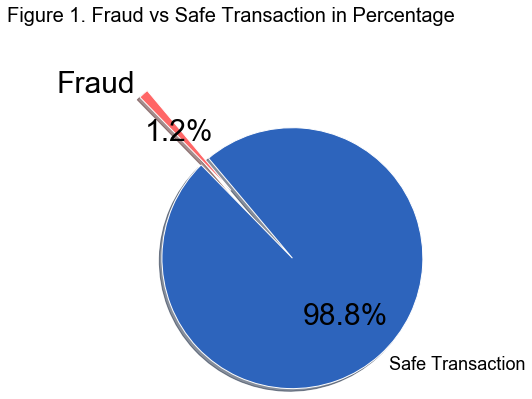



_ _ _ _ _ _ _ _ _ _  COLUMN INFORMATION & PREVIEW _ _ _ _ _ _ _ _ _ _ 



Total # of Values: 594643 
Shape: (594643, 8) 


         Parameter Nature # of Unique Entries  \
step              Feature                 180   
customer          Feature                4112   
age               Feature                   8   
gender            Feature                   4   
merchant          Feature                  50   
category          Feature                  15   
amount            Feature               23767   
fraud              Target                   2   

                        Sample Entries (First three values)  
step                                                0, 1, 2  
customer         'C1093826151', 'C352968107', 'C2054744914'  
age                                           '4', '2', '3'  
gender                                        'M', 'F', 'E'  
merchant           'M348934600', 'M1823072687', 'M50039827'  
category  'es_transportation', 'es_health', 'es_otherser...  

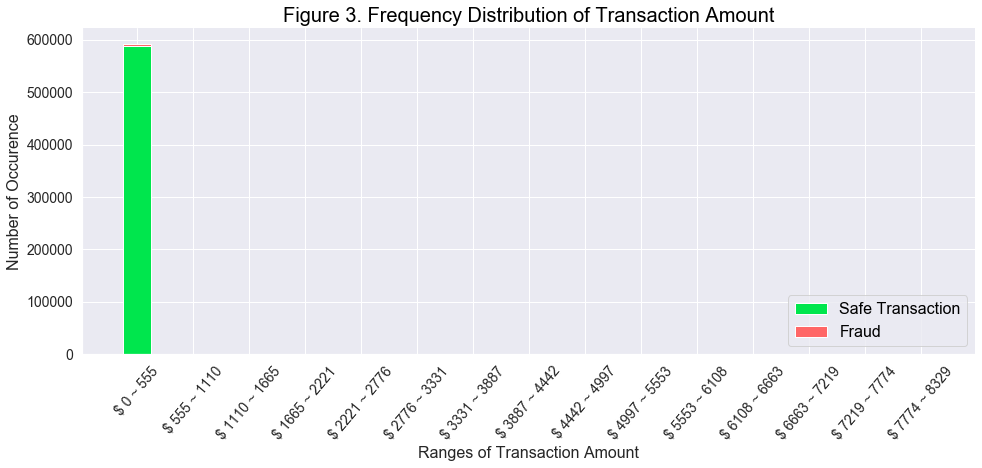



_ _ _ _ _ _ _ _ _ _  FRAUD PERCENTAGE AT DIFFERENT RANGES OF TRANSACTION AMOUNT _ _ _ _ _ _ _ _ _ _ 




<Figure size 432x432 with 0 Axes>

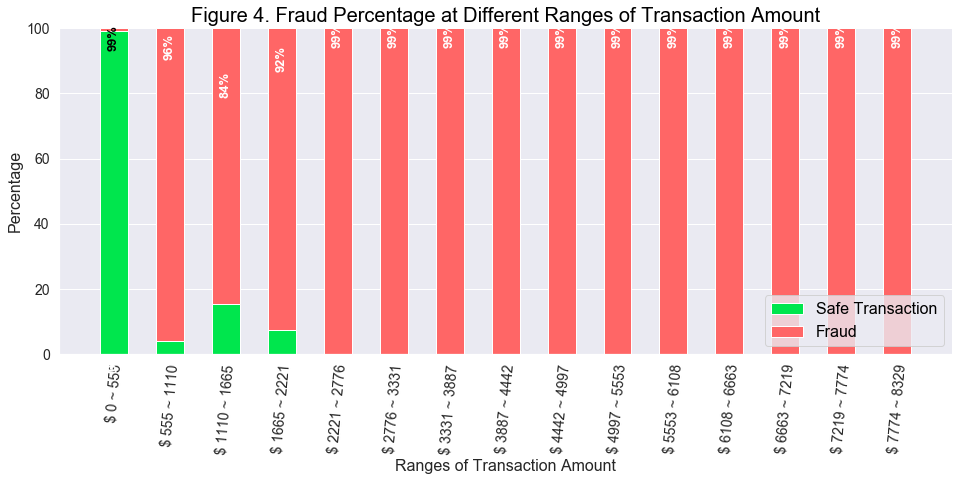



_ _ _ _ _ _ _ _ _ _  FRAUD VS NON-FRAUD HISTOGRAM _ _ _ _ _ _ _ _ _ _ 




<Figure size 432x432 with 0 Axes>

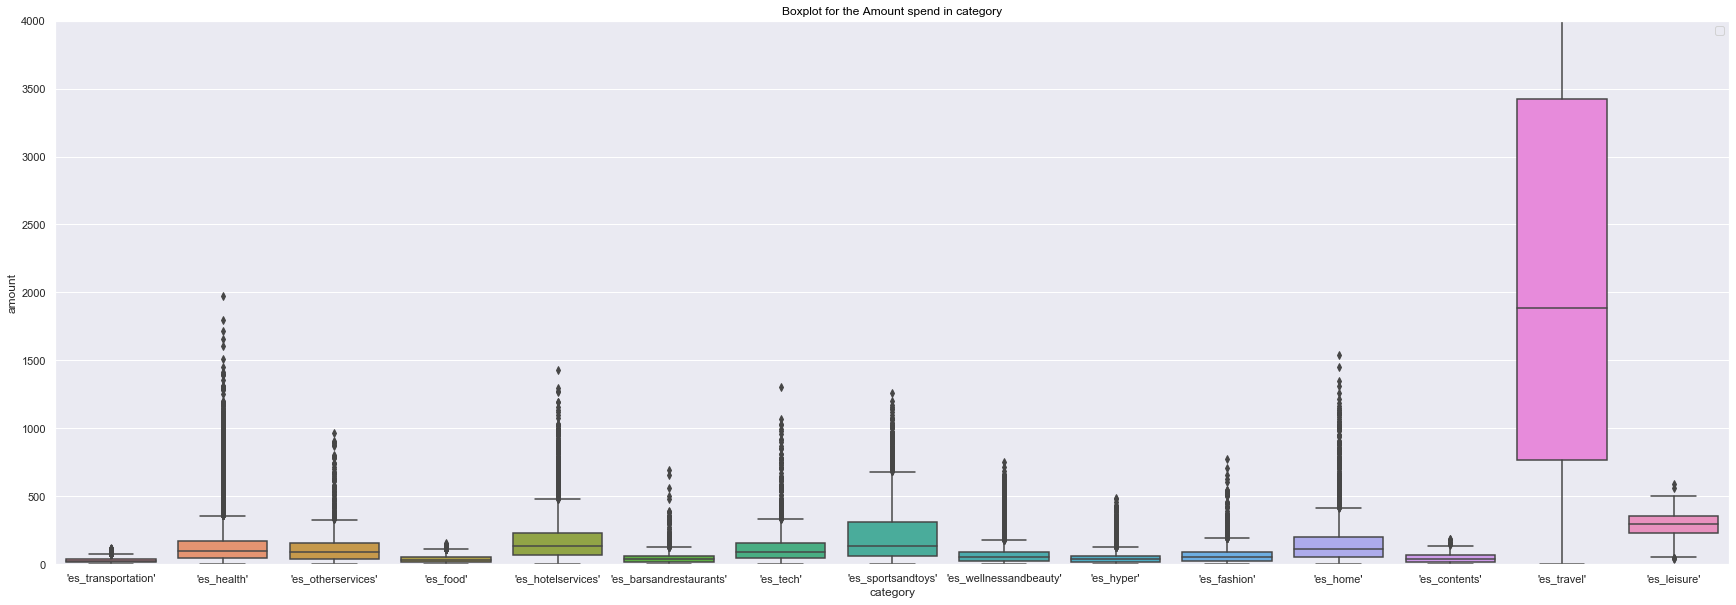



_ _ _ _ _ _ _ _ _ _  FRAUD DISTRIBUTION PER AGE _ _ _ _ _ _ _ _ _ _ 


  Age    Label  # of Fraud
1   0     <=18          48
4   1    19-25         689
7   2    26-35        2344
6   3    36-45        1755
5   4    46-55        1410
3   5    56-65         686
2   6      >65         261
0   U  Unknown           7


_ _ _ _ _ _ _ _ _ _  VISUALIZATION BEFORE TRANSFORMATION _ _ _ _ _ _ _ _ _ _ 


Total Fraud vs Non-Fraud Transactions Count: 

0    587443
1      7200
Name: fraud, dtype: int64

Number of customers:  4112
Ratio of positive frauds vs total dataset: 1.21%

Transactions per customer.
	Mean: 144.6
	Max:  265 
	Number of Batches Using Max Amount as Fixed Size: 2243.9 ~ 2244
	Number of Batches Using Mean Amount as Fixed Size: 4112.0 ~ 4112


Samples per Step (day): 
	Mean: 3304 
	Max: 3774 
	Number of Batches Using Max Amount as Fixed Size: 157.6 ~ 158
	Number of Batches Using Mean Amount as Fixed Size: 180.0 ~ 180


_ _ _ _ _ _ _ _ _ _  GROUPING TRANSACTIONS BY CUSTOMER ID _ _ _

<Figure size 432x432 with 0 Axes>

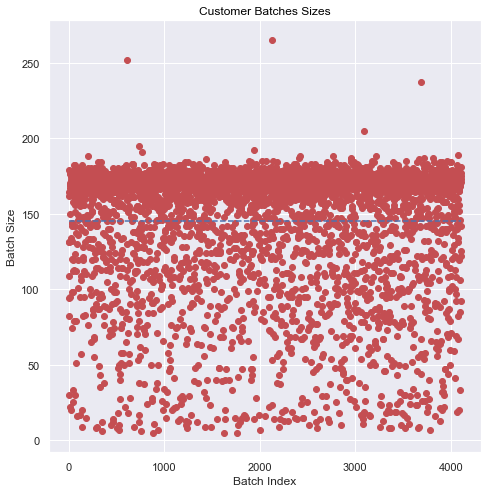



BOX PLOT SHOWING MEAN SIZE OF BATCHES GROUPED BY CUSTOMER ID: 




<Figure size 432x432 with 0 Axes>

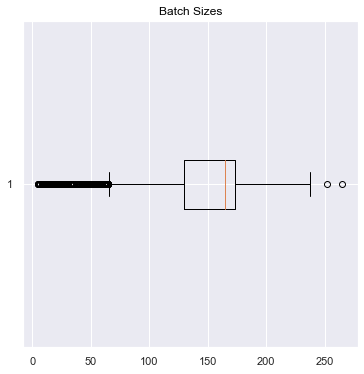



_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 265 _ _ _ _ _ _ _ _ _ _ 



      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the max number of 
      transactions done by the customers (265). If one of the customers have done less transactions,
      the rest of the empty space is filled with -1 values. The final array size is (4112, 265, 8).

 
Total Empty Rows Added:  495037 
Percentage of Empty Rows Added Compared to Total # of Data Points: % 45.43 
New Shape:  (4112, 265, 8) 
Mean of frauds per batch:  0.00024 
Percentage of frauds per batch:  9e-05


_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 145 _ _ _ _ _ _ _ _ _ _ 



      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the average number of

C:\Users\ruben\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ruben\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ruben\Documents\Github\mitacs-internship\data.py:282: RuntimeWarning: Mean of empty slice.
  ave_n_trans_per_day       =  np.round(pd.DataFrame(b[:t_i, [step_col, amount_col]][ b[:t_i, step_col ] != -1 ], index=None, columns=None).groupby(by=0).mean().reset_index().values[:, 1].mean() , 2)
  0% (6 of 4112) |                       | Elapsed Time: 0:00:00 ETA:   0:01:16

--- 3978.11 s seconds or 66.30 minutes ---
(4112, 265, 13)
[[30.  5.  2. ... -1. -1.  0.]
 [38.  5.  2. ...  9. 22.  0.]
 [42.  5.  2. ...  9. 15.  0.]
 ...
 [-1. -1. -1. ... 12. 18. -1.]
 [-1. -1. -1. ... 12. 18. -1.]
 [-1. -1. -1. ... 12. 18. -1.]]


_ _ _ _ _ _ _ _ _ _  SEPARATING IN BATCHES OF 50 _ _ _ _ _ _ _ _ _ _ 



    In the following procedure, the batches separaeted by customer and
    generated in the previous function are iterated. Each transaction
    that has been padded with value of '-1' will be deleted. new batches
    of size '50' will be generated using sliding window through each 
    transaction in every customer batch. Padding will be added for batches 
    with less transactions than the min amount '50'.
    Input Shape:                 (4112, 265, 13)
    Data Shape:                  (4112, 265, 12)
    Label Len:                   (4112, 265)
    Padding Value:               -1
    Column to check for 
    padding values to delete     0
    transaction in the

 99% (4110 of 4112) |################### | Elapsed Time: 0:02:08 ETA:   0:00:00


    X Shape: (594643, 50, 12)
    y Shape: (594643,)
    X Grouped/Cust Shape: ( 4112 , ~ MIN:5|AVE:|144.61|MAX:265 , 12  )
    y Grouped/Cust Shape: (4112, ~ MIN:5|AVE:|144.61|MAX:265 )
    
    # TRANSACTIONS GROUPS PER CUSTOMER
    Min                      : 5 
    Max                      : 265 
    Ave                      : 144.61
    Total Transaction Groups : 594643
    # Frauds & %             : 7200  - 1.21%
    # Non-Fraud & %          : 587443  - 98.79%
    % Frauds per customer    : 1.75%
    Cust Id with most fraud  : 
        ID  : 769 #-Frauds: 144 of #Trans 191 
        Note: The id is not the original. It has to be transformed using the label_hash.
    Skipped rows due to having all -1: 495037
    
Tail Sample of X 

{}

       0    1    2     3    4       5    6    7    8    9   10   11
45  -1.0 -1.0 -1.0  -1.0 -1.0   -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
46  -1.0 -1.0 -1.0  -1.0 -1.0   -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
47  -1.0 -1.0 -1.0  -1.0 -1.0   -1.00 -1.0 -1.

<Figure size 432x432 with 0 Axes>

In [7]:
empty_padding_value                = -1

data                               = read_data(input_file_path="data/bs140513_032310.csv")
visualize_data(data)
rnn_data, smaller_batches_rnn_data = generating3DRNNInput(data) 
rnn_mod_data                       = generateNewFeatures(rnn_data)
X, grouped_X, y, grouped_y         = separateInBatches(rnn_mod_data, min_batch_size=50)

# print("CT", data['customer'].value_counts() > 200 )
# print("CT", data['merchant'].value_counts())
# data.head()

In [8]:
X_norm                             = normalize3DInput(X)
y[y==empty_padding_value] = 0
X_train3, X_test3, y_train3, y_test3, X_val3, y_val3 = separatingTrainTest(X_norm, y, test_size=0.1, val_size=0.1)



_ _ _ _ _ _ _ _ _ _  SEPARATING TEST & TRAIN _ _ _ _ _ _ _ _ _ _ 


Converting 3D to 2D for easy processing. Batch Sample: 

 [[ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [


    X-TRAIN Shape: (428142, 50, 12)
    Y-TRAIN Shape: (428142,) #-Frauds: 5210 #-Non-Frauds: 422932
    X-TEST Shape:  (118929, 50, 12)
    Y-YEST Shape:  (118929,) #-Frauds: 1377 #-Non-Frauds: 117552
    Total-#-Frauds: 7200 Total-#-Non-Frauds: 587443
    



In [9]:
print("""SHAPES & KEYS:
X_train          : {}
y_train          : {}
________________________
X_test           : {}
y_test           : {}
________________________
X_val            : {}
y_val            : {}
________________________
labels_hash Keys : 
""".format(
    X_train3.shape, y_train3.shape,
    X_test3.shape,  y_test3.shape,
    X_val3.shape, y_val3.shape, 
#     labels_hash.keys() 
))

SHAPES & KEYS:
X_train          : (428142, 50, 12)
y_train          : (428142,)
________________________
X_test           : (118929, 50, 12)
y_test           : (118929,)
________________________
X_val            : (47572, 50, 12)
y_val            : (47572,)
________________________
labels_hash Keys : 



In [ ]:
pickle.dump( rnn_data      , open( "rnn_data_db.data"      , "wb" ) ) 
pickle.dump( rnn_mod_data  , open( "rnn_mod_data_db.data"  , "wb" ) ) 
pickle.dump( X_train3      , open( "X_train_db.data"       , "wb" ) ) 
pickle.dump( X_test3       , open( "X_test_db.data"        , "wb" ) )
pickle.dump( X_val3        , open( "X_val_db.data"         , "wb" ) )
pickle.dump( y_train3      , open( "y_train_db.data"       , "wb" ) )
pickle.dump( y_test3       , open( "y_test_db.data"        , "wb" ) )
pickle.dump( y_val3        , open( "y_val_db.data"         , "wb" ) )